# Applied Machine Learning
## Classification model testing
- Author: Lorien Pratt
- Copyright: Quantellia LLC 2019.  All Rights Reserved

This notebook tests a classification model against ground truth on a backtesting data set

## Setup


In [1]:
# Create a variable to distinguish my data and model files from others'
# Note that this is done inside of R, not Python, using the   construct which allows me to place
# R code on a single line
my_initials<-"jing"

In [2]:
# Run the following line of code if you get an incompatible versions error from H2o
#install.packages("h2o",
#                 type="source",
#                 repos=(c("http://h2o-release.s3.amazonaws.com/h2o/latest_stable_R")))

###### 11. Create the ROC graph along with its AUC (to be used later when we do a classification model)

In [3]:
require(h2o)
h2o.init()

Loading required package: h2o

----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:stats’:

    cor, sd, var

The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         28 minutes 47 seconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.26.0.10 
    H2O cluster version age:    6 days  
    H2O cluster name:           H2O_started_from_R_jupyter_ldd243 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   0.34 GB 
    H2O cluster total cores:    1 
    H2O cluster allowed cores:  1 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.1 (2019-07-05) 



Install a number of R packages we'll need to display the results

In [4]:
# This will generate what look like warnings, but are really notifications
# uncomment install.packages if you are on a new instance without these packages pre-installed
#install.packages("plyr")
#install.packages("pROC")
#install.packages("SDMTools")
#install.packages("RColorBrewer")
#install.packages("ggplot")
require(plyr)
require(pROC)
require(SDMTools)
require(RColorBrewer)
require(gplots)

Loading required package: plyr
Loading required package: pROC
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following object is masked from ‘package:h2o’:

    var

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: SDMTools
Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3

Attaching package: ‘SDMTools’

The following object is masked from ‘package:pROC’:

    auc

Loading required package: RColorBrewer
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



## Read the model

Create the file names from your initials, just as we did when building the files in the first place

In [8]:
train_filename<-paste0("/home/jupyter/Applied ML course/Lab 2 Iris/data/",my_initials,"_train_iris.csv"); print( train_filename )
test_filename<-paste0("/home/jupyter/Applied ML course/Lab 2 Iris/data/",my_initials,"_test_iris.csv"); print( test_filename )
backtest_filename<-paste0("/home/jupyter/Applied ML course/Lab 2 Iris/data/",my_initials,"_backtest_iris.csv"); print( backtest_filename )

[1] "/home/jupyter/Applied ML course/Lab 2 Iris/data/jing_train_iris.csv"
[1] "/home/jupyter/Applied ML course/Lab 2 Iris/data/jing_test_iris.csv"
[1] "/home/jupyter/Applied ML course/Lab 2 Iris/data/jing_backtest_iris.csv"


Read in the backtest file. Convert it to an h2o file along the way.

## Read the backtesting dataset

In [9]:
#train_hex <- h2o.importFile(train_filename, parse = TRUE, header = TRUE, 
#                            sep = "", col.names = NULL, col.types = NULL, na.strings = NULL)
#test_hex <- h2o.importFile(test_filename, parse = TRUE, header = TRUE, 
#                           sep = "", col.names = NULL, col.types = NULL, na.strings = NULL)
backtest_hex <- h2o.importFile(backtest_filename, parse = TRUE, header = TRUE, 
                           sep = "", col.names = NULL, col.types = NULL, na.strings = NULL)

  |======================================================================| 100%


In [10]:
head(backtest_hex)

sepal_length,sepal_width,petal_length,petal_width,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6.4,2.7,5.3,1.9,0
6.7,3.3,5.7,2.1,0
5.6,2.7,4.2,1.3,0
7.9,3.8,6.4,2.0,0
4.9,3.1,1.5,0.1,1
6.3,2.3,4.4,1.3,0


Set the predictor columns and check that they're the right ones

In [11]:
predictors <- c(1,2,3,4)
names(backtest_hex)[predictors]

[1] "sepal_length" "sepal_width"  "petal_length" "petal_width"

Tell the model training which of the columns is the target column (in this case, the very last column, mpg)

In [12]:
targetcol<-ncol(backtest_hex)
names(backtest_hex)[targetcol]

[1] "class"

## Read the model

In [13]:
model_pathname<-paste0("models/",my_initials,"_iris_model/model_1")
model<-h2o.loadModel(model_pathname)

## Model evalution

Generate predictions for every row in the backtest set, and create two vectors: one with the truth and one with the prediction

## Score the model against the backtesting dataset

In [14]:
predictions <- h2o.predict(model, backtest_hex)
#actual_column <- as.logical(as.vector(as.numeric(backtest_hex[ ,ncol(backtest_hex)])))
actual_column <- as.vector(as.numeric(backtest_hex[targetcol]))
predict_column <- as.vector(predictions[ ,'predict'])
str(actual_column)
str(predict_column)

  |======================================================================| 100%
 int [1:50] 0 0 0 0 1 0 0 0 1 0 ...
 num [1:50] 0.01121 -0.00718 -0.01863 -0.03531 0.99845 ...


## Compare the two vectors to generate a single 0.5-threshold Confusion Matrix (CMAT)

In [15]:
  cm<-confusion.matrix(actual_column,predict_column, 0.5)
  print(cm)

    obs
pred  0  1
   0 37  0
   1  0 13
attr(,"class")
[1] "confusion.matrix"


## Use different thresholds to generate multiple CMATs

In [16]:
for (i in c(0.001,0.01,0.2,0.5, 0.9, 0.95, 0.99,0.995,0.999)) {
  threshold<-i
  print(paste0("threshold=",threshold,":"))
  cm<-confusion.matrix(actual_column,predict_column, threshold)
  print(cm)
  tp<-cm[2,2]; fp<-cm[2,1]; tn<-cm[1,1]; fn<-cm[1,2]
  #print(paste0("tp/fp = ",tp/fp))
  print(paste0("accuracy = ",100*round((tn+tp)/(tn+tp+fn+tp),2),"%"))
}

[1] "threshold=0.001:"
    obs
pred  0  1
   0 16  0
   1 21 13
attr(,"class")
[1] "confusion.matrix"
[1] "accuracy = 69%"
[1] "threshold=0.01:"
    obs
pred  0  1
   0 28  0
   1  9 13
attr(,"class")
[1] "confusion.matrix"
[1] "accuracy = 76%"
[1] "threshold=0.2:"
    obs
pred  0  1
   0 37  0
   1  0 13
attr(,"class")
[1] "confusion.matrix"
[1] "accuracy = 79%"
[1] "threshold=0.5:"
    obs
pred  0  1
   0 37  0
   1  0 13
attr(,"class")
[1] "confusion.matrix"
[1] "accuracy = 79%"
[1] "threshold=0.9:"
    obs
pred  0  1
   0 37  0
   1  0 13
attr(,"class")
[1] "confusion.matrix"
[1] "accuracy = 79%"
[1] "threshold=0.95:"
    obs
pred  0  1
   0 37  0
   1  0 13
attr(,"class")
[1] "confusion.matrix"
[1] "accuracy = 79%"
[1] "threshold=0.99:"
    obs
pred  0 1
   0 37 5
   1  0 8
attr(,"class")
[1] "confusion.matrix"
[1] "accuracy = 78%"
[1] "threshold=0.995:"
    obs
pred  0 1
   0 37 5
   1  0 8
attr(,"class")
[1] "confusion.matrix"
[1] "accuracy = 78%"
[1] "threshold=0.999:"
    obs


## Compare the vectors to generate an ROC ("Receiver Operator Charastics") curve and to measure it's AUC (Area under the Curve)

Setting levels: control = 0, case = 1
Setting direction: controls < cases


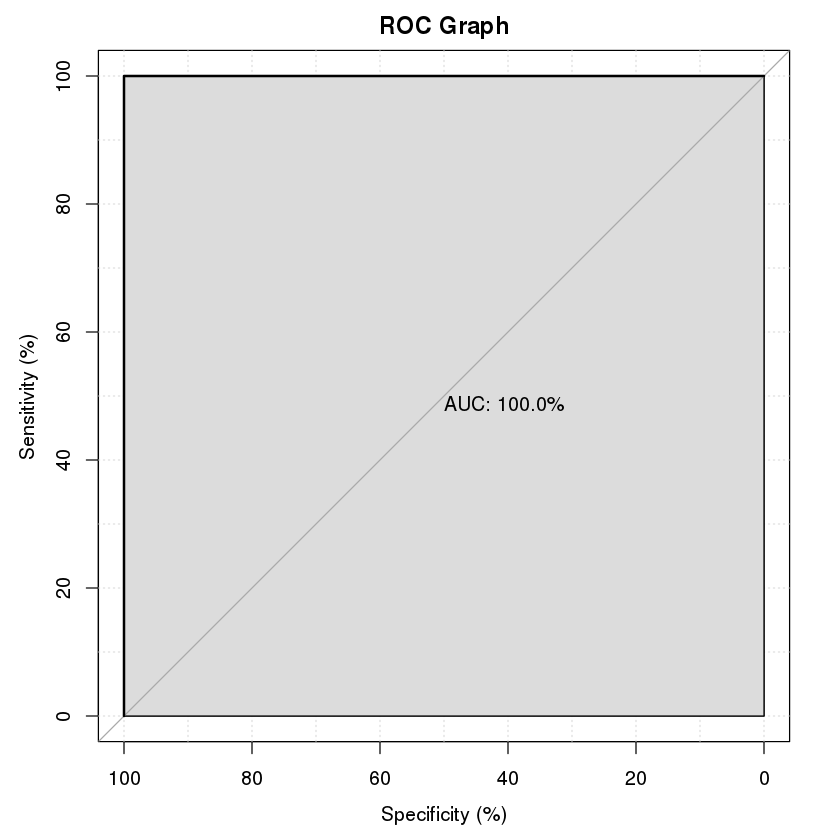

In [17]:
# Use the following code for a classification problem, not regression
# 
rocp1 <- roc(actual_column, predict_column,
        percent=TRUE,
        plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
        print.auc=TRUE, show.thres=TRUE, main="ROC Graph")

## Plot actuals versus predictions to get a visual sense of how well the model did

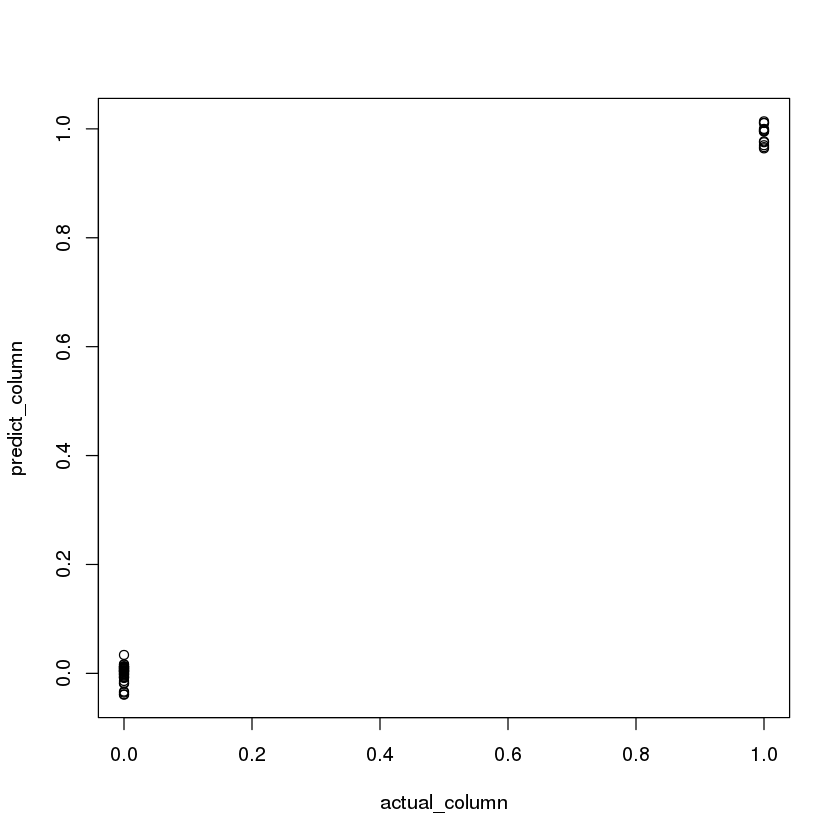

In [18]:
plot(actual_column,predict_column)

Extract the variable importances from the model and show them in a graph from most important to least important

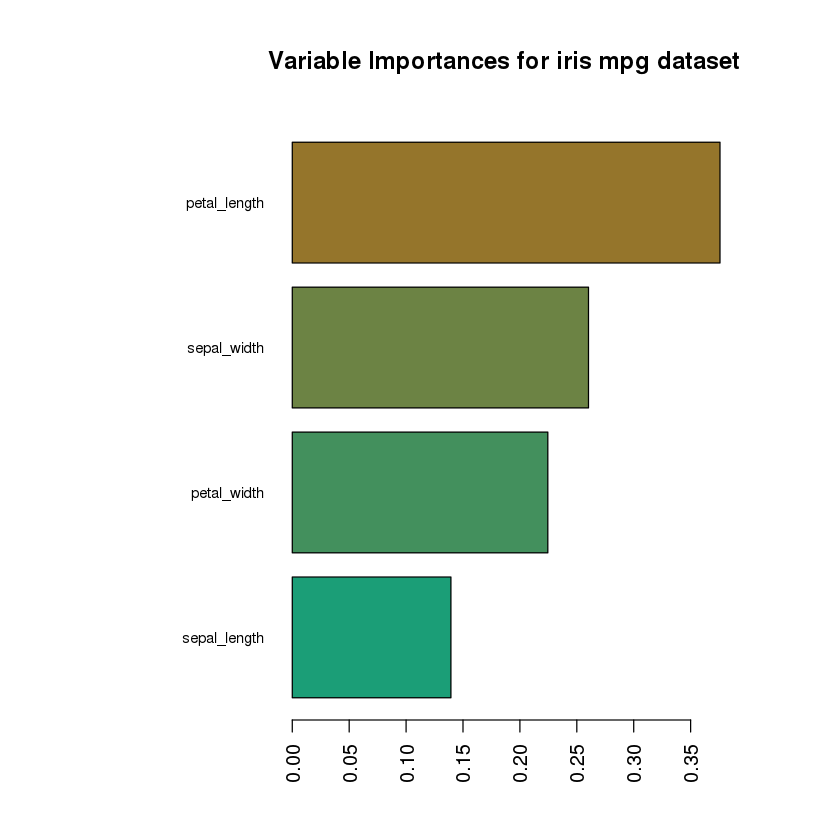

In [19]:
x<-model@model
vi<-x$variable_importances
par(mar=c(5, 12, 5, 5))
plotSize<-15
cols <- colorRampPalette(brewer.pal(4,"Dark2"))(plotSize)
barplot(rev(vi$percentage),las=2,main="Variable Importances for iris mpg dataset",
                    names.arg=rev(vi$variable),
                    horiz=TRUE,cex.names=0.75,col=cols)